# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

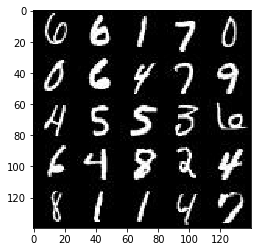

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

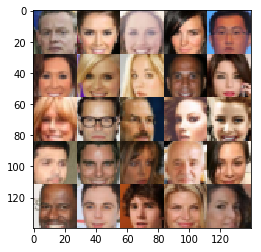

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    r_inputs = tf.placeholder(tf.float32, shape = (None, image_width, image_height, image_channels), name = 'r_inputs')
    z_inputs = tf.placeholder(tf.float32, shape = (None, z_dim), name = 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return r_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    prob = 0.85
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse = reuse):
        
        x1 = tf.layers.conv2d(images, filters = 64, kernel_size = (5,5), strides = (2,2), padding = 'SAME', kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        y1 = tf.nn.dropout(x1, keep_prob = prob)
        relu1 = tf.maximum(alpha*y1, y1)
        
        x2 = tf.layers.conv2d(x1, filters = 128, kernel_size = (5,5), strides = (2,2), padding = 'SAME', kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        y2 = tf.nn.dropout(x2, keep_prob = prob)
        bn2 = tf.layers.batch_normalization(y2, training = True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        x3 = tf.layers.conv2d(x2, filters = 256, kernel_size = (5,5), strides = (2,2), padding = 'SAME', kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        y3 = tf.nn.dropout(x3, keep_prob = prob)
        bn3 = tf.layers.batch_normalization(y3, training = True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        
        flatten = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    prob = 0.85
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse = not is_train):
        
        g1 = tf.layers.dense(z, 2*2*512)
        g1 = tf.reshape(g1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(g1, training = is_train)
        relu1 = tf.maximum(alpha*bn1, bn1)
        
        g2 = tf.layers.conv2d_transpose(relu1, filters = 256, kernel_size = (5,5), strides = (2,2), padding = 'VALID', kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        g2 = tf.nn.dropout(g2, keep_prob = prob)
        bn2 = tf.layers.batch_normalization(g2, training = is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        g3 = tf.layers.conv2d_transpose(relu2, filters = 128, kernel_size = (5,5), strides = (2,2), padding = 'SAME', kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        g3 = tf.nn.dropout(g3, keep_prob = prob)
        bn3 = tf.layers.batch_normalization(g3, training = is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        logits = tf.layers.conv2d_transpose(relu3, filters = out_channel_dim, kernel_size = (5,5), strides = (2,2), padding = 'SAME', kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    
    g_fake = generator(input_z, out_channel_dim, is_train = True)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False)
    d_model_fake, d_logits_fake = discriminator(g_fake, reuse = True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        
        d_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    alpha = 0.1
    prob = 0.85
    samples, width, height, channels = data_shape
    input_real, input_z, learning_rate_tf = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_tf, beta1)
    
    c_step = 0
    loss_print = 10
    image_print = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                c_step = c_step + 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: batch_z, learning_rate_tf:learning_rate})
                sess.run(g_opt, feed_dict = {input_real: batch_images, input_z: batch_z, learning_rate_tf:learning_rate})

                if c_step % loss_print ==0:
                    d_loss_train = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_loss_train = g_loss.eval({input_z: batch_z})
                    
                    print('Epoch {}/ {} ... '.format(epoch_i, epoch_count), "Discriminator Loss {:.4f}".format(d_loss_train), "Gen Loss {:.4f}".format(g_loss_train))
                    
                if c_step % image_print == 0:
                    n = 25
                    show_generator_output(sess, n, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/ 2 ...  Discriminator Loss 2.3294 Gen Loss 0.1918
Epoch 0/ 2 ...  Discriminator Loss 0.3522 Gen Loss 9.5217
Epoch 0/ 2 ...  Discriminator Loss 0.3664 Gen Loss 4.1486
Epoch 0/ 2 ...  Discriminator Loss 0.3983 Gen Loss 3.0673
Epoch 0/ 2 ...  Discriminator Loss 0.3653 Gen Loss 3.9431
Epoch 0/ 2 ...  Discriminator Loss 0.3779 Gen Loss 3.5535
Epoch 0/ 2 ...  Discriminator Loss 0.3771 Gen Loss 3.5279
Epoch 0/ 2 ...  Discriminator Loss 0.3782 Gen Loss 3.6429
Epoch 0/ 2 ...  Discriminator Loss 5.7255 Gen Loss 12.9606
Epoch 0/ 2 ...  Discriminator Loss 2.1027 Gen Loss 0.2005


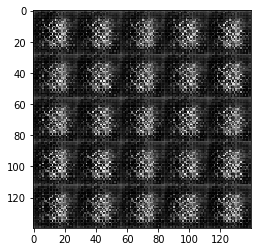

Epoch 0/ 2 ...  Discriminator Loss 0.4498 Gen Loss 2.5836
Epoch 0/ 2 ...  Discriminator Loss 1.6127 Gen Loss 0.4373
Epoch 0/ 2 ...  Discriminator Loss 1.2729 Gen Loss 3.2557
Epoch 0/ 2 ...  Discriminator Loss 0.5822 Gen Loss 2.5458
Epoch 0/ 2 ...  Discriminator Loss 0.6614 Gen Loss 2.5135
Epoch 0/ 2 ...  Discriminator Loss 0.5575 Gen Loss 2.6633
Epoch 0/ 2 ...  Discriminator Loss 0.7990 Gen Loss 1.7131
Epoch 0/ 2 ...  Discriminator Loss 0.7493 Gen Loss 3.7942
Epoch 0/ 2 ...  Discriminator Loss 0.5138 Gen Loss 2.5956
Epoch 0/ 2 ...  Discriminator Loss 0.5366 Gen Loss 2.3185


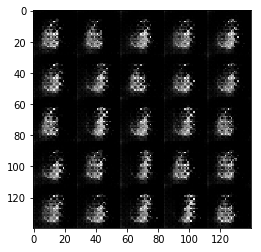

Epoch 0/ 2 ...  Discriminator Loss 0.4392 Gen Loss 4.0567
Epoch 0/ 2 ...  Discriminator Loss 0.6262 Gen Loss 1.7575
Epoch 0/ 2 ...  Discriminator Loss 0.4698 Gen Loss 2.6066
Epoch 0/ 2 ...  Discriminator Loss 0.4329 Gen Loss 2.8034
Epoch 0/ 2 ...  Discriminator Loss 0.4893 Gen Loss 2.7931
Epoch 0/ 2 ...  Discriminator Loss 0.6502 Gen Loss 1.5634
Epoch 0/ 2 ...  Discriminator Loss 0.5460 Gen Loss 2.1644
Epoch 0/ 2 ...  Discriminator Loss 0.6437 Gen Loss 2.3581
Epoch 0/ 2 ...  Discriminator Loss 0.6776 Gen Loss 2.3029
Epoch 0/ 2 ...  Discriminator Loss 0.6015 Gen Loss 2.1984


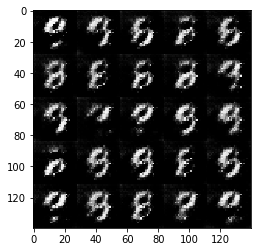

Epoch 0/ 2 ...  Discriminator Loss 0.5985 Gen Loss 2.1764
Epoch 0/ 2 ...  Discriminator Loss 0.4991 Gen Loss 3.2573
Epoch 0/ 2 ...  Discriminator Loss 0.5544 Gen Loss 2.0780
Epoch 0/ 2 ...  Discriminator Loss 0.5642 Gen Loss 2.5756
Epoch 0/ 2 ...  Discriminator Loss 0.4557 Gen Loss 3.1147
Epoch 0/ 2 ...  Discriminator Loss 0.6310 Gen Loss 2.0248
Epoch 0/ 2 ...  Discriminator Loss 0.6072 Gen Loss 1.8447
Epoch 0/ 2 ...  Discriminator Loss 0.6482 Gen Loss 1.8458
Epoch 0/ 2 ...  Discriminator Loss 0.5165 Gen Loss 2.6299
Epoch 0/ 2 ...  Discriminator Loss 0.5191 Gen Loss 2.6561


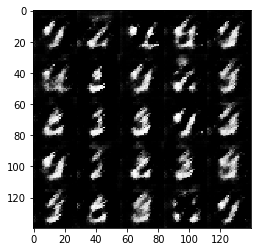

Epoch 0/ 2 ...  Discriminator Loss 0.6381 Gen Loss 2.3734
Epoch 0/ 2 ...  Discriminator Loss 0.6080 Gen Loss 2.3855
Epoch 0/ 2 ...  Discriminator Loss 0.8429 Gen Loss 1.2737
Epoch 0/ 2 ...  Discriminator Loss 0.7902 Gen Loss 2.3318
Epoch 0/ 2 ...  Discriminator Loss 0.5131 Gen Loss 2.5207
Epoch 0/ 2 ...  Discriminator Loss 0.4508 Gen Loss 2.8468
Epoch 0/ 2 ...  Discriminator Loss 0.5993 Gen Loss 1.9263
Epoch 0/ 2 ...  Discriminator Loss 0.6695 Gen Loss 1.8007
Epoch 0/ 2 ...  Discriminator Loss 0.6893 Gen Loss 2.2982
Epoch 0/ 2 ...  Discriminator Loss 0.6422 Gen Loss 1.9975


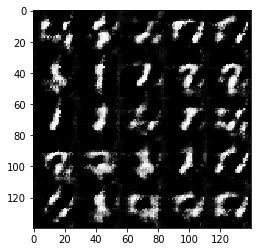

Epoch 0/ 2 ...  Discriminator Loss 0.5176 Gen Loss 2.3963
Epoch 0/ 2 ...  Discriminator Loss 0.5010 Gen Loss 2.5865
Epoch 0/ 2 ...  Discriminator Loss 0.6633 Gen Loss 1.9888
Epoch 0/ 2 ...  Discriminator Loss 0.5943 Gen Loss 2.3551
Epoch 0/ 2 ...  Discriminator Loss 0.7233 Gen Loss 2.1650
Epoch 0/ 2 ...  Discriminator Loss 0.5893 Gen Loss 2.9044
Epoch 0/ 2 ...  Discriminator Loss 0.7544 Gen Loss 2.7010
Epoch 0/ 2 ...  Discriminator Loss 0.6705 Gen Loss 1.7615
Epoch 0/ 2 ...  Discriminator Loss 0.7671 Gen Loss 1.7688
Epoch 0/ 2 ...  Discriminator Loss 0.8359 Gen Loss 1.7479


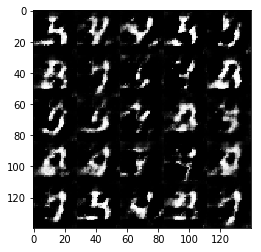

Epoch 0/ 2 ...  Discriminator Loss 0.9065 Gen Loss 1.4922
Epoch 0/ 2 ...  Discriminator Loss 0.7321 Gen Loss 2.0252
Epoch 0/ 2 ...  Discriminator Loss 0.5981 Gen Loss 2.6005
Epoch 0/ 2 ...  Discriminator Loss 0.6899 Gen Loss 2.0762
Epoch 0/ 2 ...  Discriminator Loss 0.7088 Gen Loss 2.0010
Epoch 0/ 2 ...  Discriminator Loss 0.6503 Gen Loss 2.4807
Epoch 0/ 2 ...  Discriminator Loss 0.7913 Gen Loss 1.4262
Epoch 0/ 2 ...  Discriminator Loss 0.9441 Gen Loss 1.1296
Epoch 0/ 2 ...  Discriminator Loss 0.7460 Gen Loss 1.6654
Epoch 0/ 2 ...  Discriminator Loss 0.7350 Gen Loss 1.9033


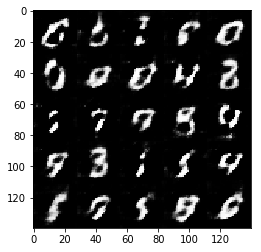

Epoch 0/ 2 ...  Discriminator Loss 0.6659 Gen Loss 1.8577
Epoch 0/ 2 ...  Discriminator Loss 0.6945 Gen Loss 2.3488
Epoch 0/ 2 ...  Discriminator Loss 0.8228 Gen Loss 2.0577
Epoch 0/ 2 ...  Discriminator Loss 0.7424 Gen Loss 1.7163
Epoch 0/ 2 ...  Discriminator Loss 0.7885 Gen Loss 1.4930
Epoch 0/ 2 ...  Discriminator Loss 0.7936 Gen Loss 1.6099
Epoch 0/ 2 ...  Discriminator Loss 0.7870 Gen Loss 1.6808
Epoch 0/ 2 ...  Discriminator Loss 0.7460 Gen Loss 2.0955
Epoch 0/ 2 ...  Discriminator Loss 0.8923 Gen Loss 1.9103
Epoch 0/ 2 ...  Discriminator Loss 0.8263 Gen Loss 1.8684


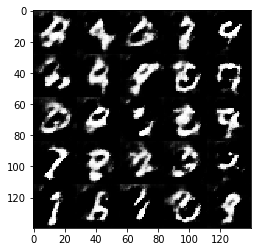

Epoch 0/ 2 ...  Discriminator Loss 0.9489 Gen Loss 1.5273
Epoch 0/ 2 ...  Discriminator Loss 1.2866 Gen Loss 1.2916
Epoch 0/ 2 ...  Discriminator Loss 0.8299 Gen Loss 1.2247
Epoch 0/ 2 ...  Discriminator Loss 1.0390 Gen Loss 0.9922
Epoch 0/ 2 ...  Discriminator Loss 0.7295 Gen Loss 1.6656
Epoch 0/ 2 ...  Discriminator Loss 0.8933 Gen Loss 1.8291
Epoch 0/ 2 ...  Discriminator Loss 1.1603 Gen Loss 1.2542
Epoch 0/ 2 ...  Discriminator Loss 0.9105 Gen Loss 1.3543
Epoch 0/ 2 ...  Discriminator Loss 1.2366 Gen Loss 0.9434
Epoch 0/ 2 ...  Discriminator Loss 1.2115 Gen Loss 1.3806


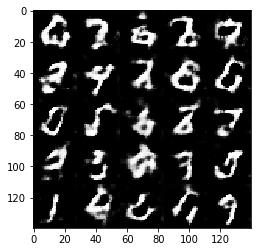

Epoch 0/ 2 ...  Discriminator Loss 1.0405 Gen Loss 1.3572
Epoch 0/ 2 ...  Discriminator Loss 1.1500 Gen Loss 1.1071
Epoch 0/ 2 ...  Discriminator Loss 0.8828 Gen Loss 1.5324
Epoch 0/ 2 ...  Discriminator Loss 1.2250 Gen Loss 1.6190
Epoch 0/ 2 ...  Discriminator Loss 1.0441 Gen Loss 1.3335
Epoch 0/ 2 ...  Discriminator Loss 1.0066 Gen Loss 1.4520
Epoch 0/ 2 ...  Discriminator Loss 1.2993 Gen Loss 0.9420
Epoch 0/ 2 ...  Discriminator Loss 0.9702 Gen Loss 1.4401
Epoch 0/ 2 ...  Discriminator Loss 0.8596 Gen Loss 1.5292
Epoch 0/ 2 ...  Discriminator Loss 0.9904 Gen Loss 1.3549


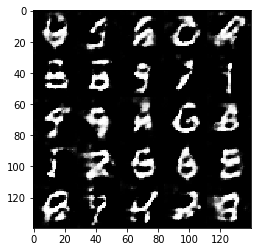

Epoch 0/ 2 ...  Discriminator Loss 0.9795 Gen Loss 1.6074
Epoch 0/ 2 ...  Discriminator Loss 1.2327 Gen Loss 1.1003
Epoch 0/ 2 ...  Discriminator Loss 0.9850 Gen Loss 1.3869
Epoch 0/ 2 ...  Discriminator Loss 1.2284 Gen Loss 1.1453
Epoch 0/ 2 ...  Discriminator Loss 1.0085 Gen Loss 1.3498
Epoch 0/ 2 ...  Discriminator Loss 0.9500 Gen Loss 1.3375
Epoch 0/ 2 ...  Discriminator Loss 1.1950 Gen Loss 1.1013
Epoch 0/ 2 ...  Discriminator Loss 0.7781 Gen Loss 1.6883
Epoch 0/ 2 ...  Discriminator Loss 1.0586 Gen Loss 0.9873
Epoch 0/ 2 ...  Discriminator Loss 0.9760 Gen Loss 1.4225


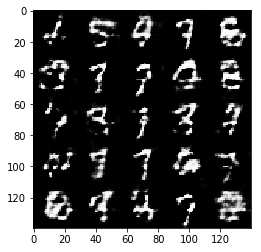

Epoch 0/ 2 ...  Discriminator Loss 1.1022 Gen Loss 1.2668
Epoch 0/ 2 ...  Discriminator Loss 0.7847 Gen Loss 1.8991
Epoch 0/ 2 ...  Discriminator Loss 1.1170 Gen Loss 1.2892
Epoch 0/ 2 ...  Discriminator Loss 1.0499 Gen Loss 1.3146
Epoch 0/ 2 ...  Discriminator Loss 1.2422 Gen Loss 1.0426
Epoch 0/ 2 ...  Discriminator Loss 1.1465 Gen Loss 0.9764
Epoch 0/ 2 ...  Discriminator Loss 1.1791 Gen Loss 1.1396
Epoch 0/ 2 ...  Discriminator Loss 1.1513 Gen Loss 1.0957
Epoch 0/ 2 ...  Discriminator Loss 1.0910 Gen Loss 1.3482
Epoch 0/ 2 ...  Discriminator Loss 1.0283 Gen Loss 1.2221


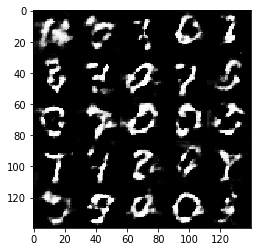

Epoch 0/ 2 ...  Discriminator Loss 1.0505 Gen Loss 1.2517
Epoch 0/ 2 ...  Discriminator Loss 1.1984 Gen Loss 1.0790
Epoch 0/ 2 ...  Discriminator Loss 1.2439 Gen Loss 1.2020
Epoch 0/ 2 ...  Discriminator Loss 1.0140 Gen Loss 1.1439
Epoch 0/ 2 ...  Discriminator Loss 1.0161 Gen Loss 1.2610
Epoch 0/ 2 ...  Discriminator Loss 1.0865 Gen Loss 1.0451
Epoch 0/ 2 ...  Discriminator Loss 1.1004 Gen Loss 0.9102
Epoch 0/ 2 ...  Discriminator Loss 0.8522 Gen Loss 1.4352
Epoch 0/ 2 ...  Discriminator Loss 1.1238 Gen Loss 1.2506
Epoch 0/ 2 ...  Discriminator Loss 1.2872 Gen Loss 0.9178


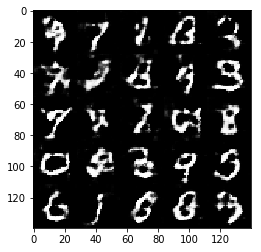

Epoch 0/ 2 ...  Discriminator Loss 1.2433 Gen Loss 0.8914
Epoch 0/ 2 ...  Discriminator Loss 1.1850 Gen Loss 0.9117
Epoch 0/ 2 ...  Discriminator Loss 1.0685 Gen Loss 1.1753
Epoch 0/ 2 ...  Discriminator Loss 0.9599 Gen Loss 1.3172
Epoch 0/ 2 ...  Discriminator Loss 1.0389 Gen Loss 1.2491
Epoch 0/ 2 ...  Discriminator Loss 1.0454 Gen Loss 1.1987
Epoch 0/ 2 ...  Discriminator Loss 1.2548 Gen Loss 1.1207
Epoch 0/ 2 ...  Discriminator Loss 0.9991 Gen Loss 1.1892
Epoch 0/ 2 ...  Discriminator Loss 1.1353 Gen Loss 1.1550
Epoch 0/ 2 ...  Discriminator Loss 1.1918 Gen Loss 1.0672


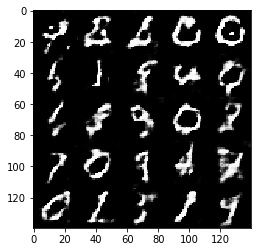

Epoch 0/ 2 ...  Discriminator Loss 1.3003 Gen Loss 1.0635
Epoch 0/ 2 ...  Discriminator Loss 1.1682 Gen Loss 1.0674
Epoch 0/ 2 ...  Discriminator Loss 1.1210 Gen Loss 1.0149
Epoch 0/ 2 ...  Discriminator Loss 1.0951 Gen Loss 1.1276
Epoch 0/ 2 ...  Discriminator Loss 1.1767 Gen Loss 1.0111
Epoch 0/ 2 ...  Discriminator Loss 1.0393 Gen Loss 1.1497
Epoch 0/ 2 ...  Discriminator Loss 0.9750 Gen Loss 1.4633
Epoch 0/ 2 ...  Discriminator Loss 1.0592 Gen Loss 1.1002
Epoch 0/ 2 ...  Discriminator Loss 1.3157 Gen Loss 0.9809
Epoch 0/ 2 ...  Discriminator Loss 1.2086 Gen Loss 1.1596


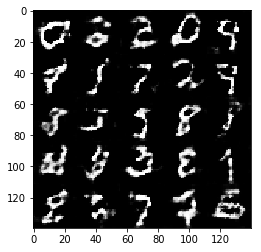

Epoch 0/ 2 ...  Discriminator Loss 1.1864 Gen Loss 1.0537
Epoch 0/ 2 ...  Discriminator Loss 1.0103 Gen Loss 1.3140
Epoch 0/ 2 ...  Discriminator Loss 1.2641 Gen Loss 1.0149
Epoch 0/ 2 ...  Discriminator Loss 1.1089 Gen Loss 1.0930
Epoch 0/ 2 ...  Discriminator Loss 1.1541 Gen Loss 1.0871
Epoch 0/ 2 ...  Discriminator Loss 1.0861 Gen Loss 1.1596
Epoch 0/ 2 ...  Discriminator Loss 1.2438 Gen Loss 1.1100
Epoch 0/ 2 ...  Discriminator Loss 1.1502 Gen Loss 1.3178
Epoch 0/ 2 ...  Discriminator Loss 1.1834 Gen Loss 1.0969
Epoch 0/ 2 ...  Discriminator Loss 1.1593 Gen Loss 1.0224


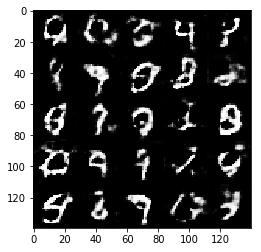

Epoch 0/ 2 ...  Discriminator Loss 1.2153 Gen Loss 1.1655
Epoch 0/ 2 ...  Discriminator Loss 1.2123 Gen Loss 1.1890
Epoch 0/ 2 ...  Discriminator Loss 1.1303 Gen Loss 1.0873
Epoch 0/ 2 ...  Discriminator Loss 1.1563 Gen Loss 1.1960
Epoch 0/ 2 ...  Discriminator Loss 1.0919 Gen Loss 1.0712
Epoch 0/ 2 ...  Discriminator Loss 1.1989 Gen Loss 0.9888
Epoch 0/ 2 ...  Discriminator Loss 1.1358 Gen Loss 1.0317
Epoch 0/ 2 ...  Discriminator Loss 1.1888 Gen Loss 0.9090
Epoch 0/ 2 ...  Discriminator Loss 1.2760 Gen Loss 1.0125
Epoch 0/ 2 ...  Discriminator Loss 1.3481 Gen Loss 1.0500


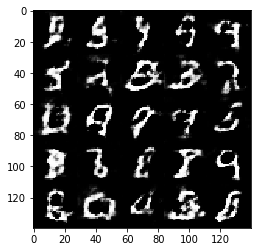

Epoch 0/ 2 ...  Discriminator Loss 1.1082 Gen Loss 0.9474
Epoch 0/ 2 ...  Discriminator Loss 1.1034 Gen Loss 1.0414
Epoch 0/ 2 ...  Discriminator Loss 1.0489 Gen Loss 1.2967
Epoch 0/ 2 ...  Discriminator Loss 1.1803 Gen Loss 1.0749
Epoch 0/ 2 ...  Discriminator Loss 1.0897 Gen Loss 1.0507
Epoch 0/ 2 ...  Discriminator Loss 1.0777 Gen Loss 1.1001
Epoch 0/ 2 ...  Discriminator Loss 1.2885 Gen Loss 0.9438
Epoch 0/ 2 ...  Discriminator Loss 1.3446 Gen Loss 0.8574
Epoch 0/ 2 ...  Discriminator Loss 1.1225 Gen Loss 1.0331
Epoch 0/ 2 ...  Discriminator Loss 1.0190 Gen Loss 1.2564


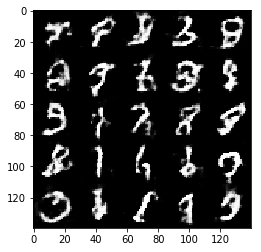

Epoch 0/ 2 ...  Discriminator Loss 1.0860 Gen Loss 1.1533
Epoch 0/ 2 ...  Discriminator Loss 1.0991 Gen Loss 1.1364
Epoch 0/ 2 ...  Discriminator Loss 1.1805 Gen Loss 0.9925
Epoch 0/ 2 ...  Discriminator Loss 1.2947 Gen Loss 1.0126
Epoch 0/ 2 ...  Discriminator Loss 1.2272 Gen Loss 1.0642
Epoch 0/ 2 ...  Discriminator Loss 1.2103 Gen Loss 0.8980
Epoch 0/ 2 ...  Discriminator Loss 1.1048 Gen Loss 1.0318
Epoch 1/ 2 ...  Discriminator Loss 1.1855 Gen Loss 1.0884
Epoch 1/ 2 ...  Discriminator Loss 1.1915 Gen Loss 0.9633
Epoch 1/ 2 ...  Discriminator Loss 1.0742 Gen Loss 1.1729


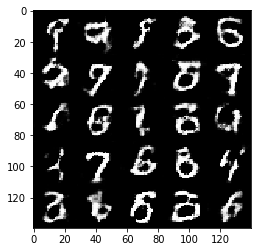

Epoch 1/ 2 ...  Discriminator Loss 1.2358 Gen Loss 0.9689
Epoch 1/ 2 ...  Discriminator Loss 1.1281 Gen Loss 1.0321
Epoch 1/ 2 ...  Discriminator Loss 1.2314 Gen Loss 1.0678
Epoch 1/ 2 ...  Discriminator Loss 1.2631 Gen Loss 0.8631
Epoch 1/ 2 ...  Discriminator Loss 1.1797 Gen Loss 1.0389
Epoch 1/ 2 ...  Discriminator Loss 1.1981 Gen Loss 0.9827
Epoch 1/ 2 ...  Discriminator Loss 1.2312 Gen Loss 0.9494
Epoch 1/ 2 ...  Discriminator Loss 1.1968 Gen Loss 1.0393
Epoch 1/ 2 ...  Discriminator Loss 1.1732 Gen Loss 1.0840
Epoch 1/ 2 ...  Discriminator Loss 1.2325 Gen Loss 1.1569


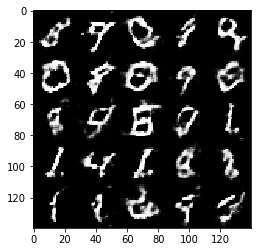

Epoch 1/ 2 ...  Discriminator Loss 1.1827 Gen Loss 1.0549
Epoch 1/ 2 ...  Discriminator Loss 1.1359 Gen Loss 1.0212
Epoch 1/ 2 ...  Discriminator Loss 1.1682 Gen Loss 1.2369
Epoch 1/ 2 ...  Discriminator Loss 1.1299 Gen Loss 0.9690
Epoch 1/ 2 ...  Discriminator Loss 1.2225 Gen Loss 0.9983
Epoch 1/ 2 ...  Discriminator Loss 1.3332 Gen Loss 0.9998
Epoch 1/ 2 ...  Discriminator Loss 1.1796 Gen Loss 1.1016
Epoch 1/ 2 ...  Discriminator Loss 1.0922 Gen Loss 1.0722
Epoch 1/ 2 ...  Discriminator Loss 1.1089 Gen Loss 1.0455
Epoch 1/ 2 ...  Discriminator Loss 1.3422 Gen Loss 0.9453


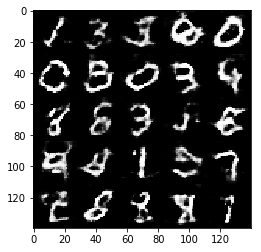

Epoch 1/ 2 ...  Discriminator Loss 1.1167 Gen Loss 1.0417
Epoch 1/ 2 ...  Discriminator Loss 1.0320 Gen Loss 1.0677
Epoch 1/ 2 ...  Discriminator Loss 1.2634 Gen Loss 0.8680
Epoch 1/ 2 ...  Discriminator Loss 1.2857 Gen Loss 0.8407
Epoch 1/ 2 ...  Discriminator Loss 1.1049 Gen Loss 1.0119
Epoch 1/ 2 ...  Discriminator Loss 1.2153 Gen Loss 1.0559
Epoch 1/ 2 ...  Discriminator Loss 1.1642 Gen Loss 1.1476
Epoch 1/ 2 ...  Discriminator Loss 1.1064 Gen Loss 1.0763
Epoch 1/ 2 ...  Discriminator Loss 1.1851 Gen Loss 1.0172
Epoch 1/ 2 ...  Discriminator Loss 1.3315 Gen Loss 0.8752


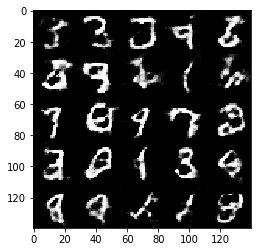

Epoch 1/ 2 ...  Discriminator Loss 1.1940 Gen Loss 0.9382
Epoch 1/ 2 ...  Discriminator Loss 1.1077 Gen Loss 0.9260
Epoch 1/ 2 ...  Discriminator Loss 1.1840 Gen Loss 0.9339
Epoch 1/ 2 ...  Discriminator Loss 1.2491 Gen Loss 0.9356
Epoch 1/ 2 ...  Discriminator Loss 1.0789 Gen Loss 1.2589
Epoch 1/ 2 ...  Discriminator Loss 1.1113 Gen Loss 1.3406
Epoch 1/ 2 ...  Discriminator Loss 1.1468 Gen Loss 0.8034
Epoch 1/ 2 ...  Discriminator Loss 1.2930 Gen Loss 0.9264
Epoch 1/ 2 ...  Discriminator Loss 1.0966 Gen Loss 1.0753
Epoch 1/ 2 ...  Discriminator Loss 1.2805 Gen Loss 1.0877


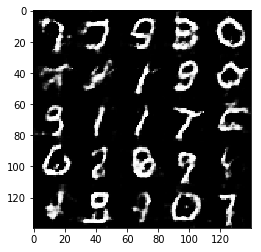

Epoch 1/ 2 ...  Discriminator Loss 1.0907 Gen Loss 1.0181
Epoch 1/ 2 ...  Discriminator Loss 1.2667 Gen Loss 0.9205
Epoch 1/ 2 ...  Discriminator Loss 1.2097 Gen Loss 0.9931
Epoch 1/ 2 ...  Discriminator Loss 1.2302 Gen Loss 1.0138
Epoch 1/ 2 ...  Discriminator Loss 1.2310 Gen Loss 1.0491
Epoch 1/ 2 ...  Discriminator Loss 1.1740 Gen Loss 0.9278
Epoch 1/ 2 ...  Discriminator Loss 1.0606 Gen Loss 0.9978
Epoch 1/ 2 ...  Discriminator Loss 1.2660 Gen Loss 1.0912
Epoch 1/ 2 ...  Discriminator Loss 1.2498 Gen Loss 0.9337
Epoch 1/ 2 ...  Discriminator Loss 1.2359 Gen Loss 0.9417


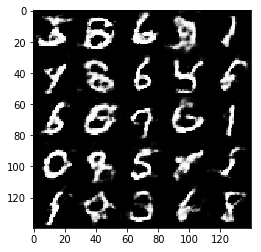

Epoch 1/ 2 ...  Discriminator Loss 1.1886 Gen Loss 0.9204
Epoch 1/ 2 ...  Discriminator Loss 1.1524 Gen Loss 1.0178
Epoch 1/ 2 ...  Discriminator Loss 1.2460 Gen Loss 0.8407
Epoch 1/ 2 ...  Discriminator Loss 1.2004 Gen Loss 1.0798
Epoch 1/ 2 ...  Discriminator Loss 1.2528 Gen Loss 0.8739
Epoch 1/ 2 ...  Discriminator Loss 1.1117 Gen Loss 1.0257
Epoch 1/ 2 ...  Discriminator Loss 1.1741 Gen Loss 0.9766
Epoch 1/ 2 ...  Discriminator Loss 1.1458 Gen Loss 0.9997
Epoch 1/ 2 ...  Discriminator Loss 1.1464 Gen Loss 1.0421
Epoch 1/ 2 ...  Discriminator Loss 1.2223 Gen Loss 0.9877


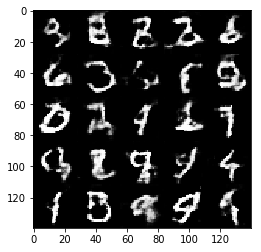

Epoch 1/ 2 ...  Discriminator Loss 1.1395 Gen Loss 0.9316
Epoch 1/ 2 ...  Discriminator Loss 1.0982 Gen Loss 1.0023
Epoch 1/ 2 ...  Discriminator Loss 1.0876 Gen Loss 1.0936
Epoch 1/ 2 ...  Discriminator Loss 1.2235 Gen Loss 0.9636
Epoch 1/ 2 ...  Discriminator Loss 1.1708 Gen Loss 0.9713
Epoch 1/ 2 ...  Discriminator Loss 1.1310 Gen Loss 0.9645
Epoch 1/ 2 ...  Discriminator Loss 1.2278 Gen Loss 1.0205
Epoch 1/ 2 ...  Discriminator Loss 1.1178 Gen Loss 1.1610
Epoch 1/ 2 ...  Discriminator Loss 1.1869 Gen Loss 1.0052
Epoch 1/ 2 ...  Discriminator Loss 1.1893 Gen Loss 1.0021


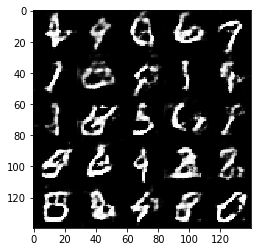

Epoch 1/ 2 ...  Discriminator Loss 1.1592 Gen Loss 1.0026
Epoch 1/ 2 ...  Discriminator Loss 1.3125 Gen Loss 0.8070
Epoch 1/ 2 ...  Discriminator Loss 1.2194 Gen Loss 1.0376
Epoch 1/ 2 ...  Discriminator Loss 1.1910 Gen Loss 1.0243
Epoch 1/ 2 ...  Discriminator Loss 1.1351 Gen Loss 1.0386
Epoch 1/ 2 ...  Discriminator Loss 1.3068 Gen Loss 0.9516
Epoch 1/ 2 ...  Discriminator Loss 1.0635 Gen Loss 1.1287
Epoch 1/ 2 ...  Discriminator Loss 1.2221 Gen Loss 0.8670
Epoch 1/ 2 ...  Discriminator Loss 1.2600 Gen Loss 1.1225
Epoch 1/ 2 ...  Discriminator Loss 1.1512 Gen Loss 1.0162


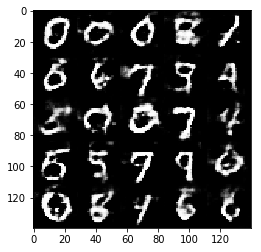

Epoch 1/ 2 ...  Discriminator Loss 1.1411 Gen Loss 1.0169
Epoch 1/ 2 ...  Discriminator Loss 1.2149 Gen Loss 0.9739
Epoch 1/ 2 ...  Discriminator Loss 1.1558 Gen Loss 1.0263
Epoch 1/ 2 ...  Discriminator Loss 1.1926 Gen Loss 0.9812
Epoch 1/ 2 ...  Discriminator Loss 1.1976 Gen Loss 0.9810
Epoch 1/ 2 ...  Discriminator Loss 1.1209 Gen Loss 0.9151
Epoch 1/ 2 ...  Discriminator Loss 1.2559 Gen Loss 0.9620
Epoch 1/ 2 ...  Discriminator Loss 1.3908 Gen Loss 0.8967
Epoch 1/ 2 ...  Discriminator Loss 1.4698 Gen Loss 0.8304
Epoch 1/ 2 ...  Discriminator Loss 1.2851 Gen Loss 0.8562


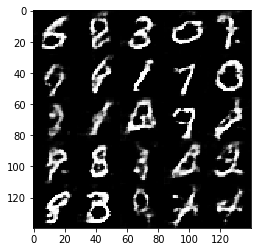

Epoch 1/ 2 ...  Discriminator Loss 1.2804 Gen Loss 0.9218
Epoch 1/ 2 ...  Discriminator Loss 1.2190 Gen Loss 0.9937
Epoch 1/ 2 ...  Discriminator Loss 1.2229 Gen Loss 0.9948
Epoch 1/ 2 ...  Discriminator Loss 1.1692 Gen Loss 1.0764
Epoch 1/ 2 ...  Discriminator Loss 1.2093 Gen Loss 1.0225
Epoch 1/ 2 ...  Discriminator Loss 1.1998 Gen Loss 0.9261
Epoch 1/ 2 ...  Discriminator Loss 0.9802 Gen Loss 0.9872
Epoch 1/ 2 ...  Discriminator Loss 1.3050 Gen Loss 0.9565
Epoch 1/ 2 ...  Discriminator Loss 1.0829 Gen Loss 1.1087
Epoch 1/ 2 ...  Discriminator Loss 1.2124 Gen Loss 1.0018


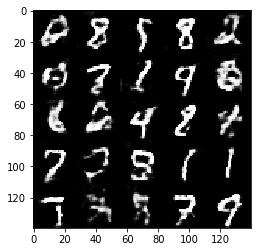

Epoch 1/ 2 ...  Discriminator Loss 1.1253 Gen Loss 0.9961
Epoch 1/ 2 ...  Discriminator Loss 1.3330 Gen Loss 0.9948
Epoch 1/ 2 ...  Discriminator Loss 1.2477 Gen Loss 0.9636
Epoch 1/ 2 ...  Discriminator Loss 1.1217 Gen Loss 1.0659
Epoch 1/ 2 ...  Discriminator Loss 1.1938 Gen Loss 0.9443
Epoch 1/ 2 ...  Discriminator Loss 1.1218 Gen Loss 1.0577
Epoch 1/ 2 ...  Discriminator Loss 1.0623 Gen Loss 1.0885
Epoch 1/ 2 ...  Discriminator Loss 1.1767 Gen Loss 0.9827
Epoch 1/ 2 ...  Discriminator Loss 1.2982 Gen Loss 0.9552
Epoch 1/ 2 ...  Discriminator Loss 1.2414 Gen Loss 1.0825


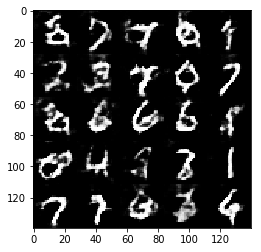

Epoch 1/ 2 ...  Discriminator Loss 1.1650 Gen Loss 0.9804
Epoch 1/ 2 ...  Discriminator Loss 1.3615 Gen Loss 0.9117
Epoch 1/ 2 ...  Discriminator Loss 1.2045 Gen Loss 1.0758
Epoch 1/ 2 ...  Discriminator Loss 1.3023 Gen Loss 0.9340
Epoch 1/ 2 ...  Discriminator Loss 1.3173 Gen Loss 0.8849
Epoch 1/ 2 ...  Discriminator Loss 1.2796 Gen Loss 0.9884
Epoch 1/ 2 ...  Discriminator Loss 1.1959 Gen Loss 0.9323
Epoch 1/ 2 ...  Discriminator Loss 1.1703 Gen Loss 1.0146
Epoch 1/ 2 ...  Discriminator Loss 1.2594 Gen Loss 0.9776
Epoch 1/ 2 ...  Discriminator Loss 1.2296 Gen Loss 0.9889


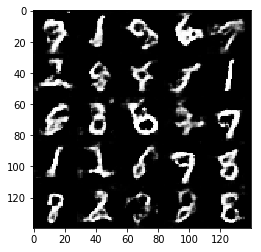

Epoch 1/ 2 ...  Discriminator Loss 1.3075 Gen Loss 0.8519
Epoch 1/ 2 ...  Discriminator Loss 1.2923 Gen Loss 0.9161
Epoch 1/ 2 ...  Discriminator Loss 1.1616 Gen Loss 1.0368
Epoch 1/ 2 ...  Discriminator Loss 1.2600 Gen Loss 0.8277
Epoch 1/ 2 ...  Discriminator Loss 1.3597 Gen Loss 0.8331
Epoch 1/ 2 ...  Discriminator Loss 1.2385 Gen Loss 0.9651
Epoch 1/ 2 ...  Discriminator Loss 1.2941 Gen Loss 1.0424
Epoch 1/ 2 ...  Discriminator Loss 1.2736 Gen Loss 0.8237
Epoch 1/ 2 ...  Discriminator Loss 1.3261 Gen Loss 0.8971
Epoch 1/ 2 ...  Discriminator Loss 1.1935 Gen Loss 0.9782


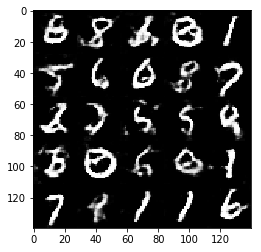

Epoch 1/ 2 ...  Discriminator Loss 1.2074 Gen Loss 0.9806
Epoch 1/ 2 ...  Discriminator Loss 1.2638 Gen Loss 0.9774
Epoch 1/ 2 ...  Discriminator Loss 1.2764 Gen Loss 1.0916
Epoch 1/ 2 ...  Discriminator Loss 1.1486 Gen Loss 0.9879
Epoch 1/ 2 ...  Discriminator Loss 1.2604 Gen Loss 0.9440
Epoch 1/ 2 ...  Discriminator Loss 1.1933 Gen Loss 1.0199
Epoch 1/ 2 ...  Discriminator Loss 1.3426 Gen Loss 0.7927
Epoch 1/ 2 ...  Discriminator Loss 1.2657 Gen Loss 0.9581
Epoch 1/ 2 ...  Discriminator Loss 1.2008 Gen Loss 0.8844
Epoch 1/ 2 ...  Discriminator Loss 1.2437 Gen Loss 1.0780


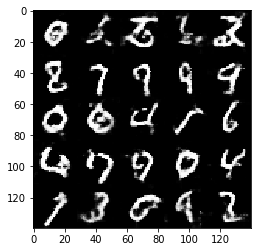

Epoch 1/ 2 ...  Discriminator Loss 1.2298 Gen Loss 1.0296
Epoch 1/ 2 ...  Discriminator Loss 1.2667 Gen Loss 0.9671
Epoch 1/ 2 ...  Discriminator Loss 1.2323 Gen Loss 0.9512
Epoch 1/ 2 ...  Discriminator Loss 1.3235 Gen Loss 0.9304
Epoch 1/ 2 ...  Discriminator Loss 1.2481 Gen Loss 0.9573
Epoch 1/ 2 ...  Discriminator Loss 1.1892 Gen Loss 0.9812
Epoch 1/ 2 ...  Discriminator Loss 1.2597 Gen Loss 0.9420
Epoch 1/ 2 ...  Discriminator Loss 1.2641 Gen Loss 0.8172
Epoch 1/ 2 ...  Discriminator Loss 1.3118 Gen Loss 0.9903
Epoch 1/ 2 ...  Discriminator Loss 1.2749 Gen Loss 0.9516


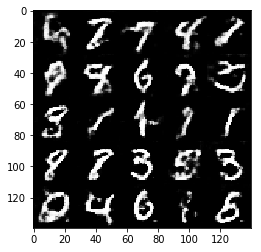

Epoch 1/ 2 ...  Discriminator Loss 1.1911 Gen Loss 0.9178
Epoch 1/ 2 ...  Discriminator Loss 1.3110 Gen Loss 0.9122
Epoch 1/ 2 ...  Discriminator Loss 1.1107 Gen Loss 0.9744
Epoch 1/ 2 ...  Discriminator Loss 1.1529 Gen Loss 0.9474
Epoch 1/ 2 ...  Discriminator Loss 1.2253 Gen Loss 0.9930
Epoch 1/ 2 ...  Discriminator Loss 1.2259 Gen Loss 0.9073
Epoch 1/ 2 ...  Discriminator Loss 1.4125 Gen Loss 0.8472
Epoch 1/ 2 ...  Discriminator Loss 1.2072 Gen Loss 0.9276
Epoch 1/ 2 ...  Discriminator Loss 1.0806 Gen Loss 1.1088
Epoch 1/ 2 ...  Discriminator Loss 1.1669 Gen Loss 0.8469


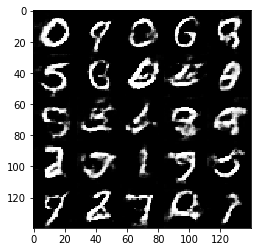

Epoch 1/ 2 ...  Discriminator Loss 1.2822 Gen Loss 0.9386
Epoch 1/ 2 ...  Discriminator Loss 1.3090 Gen Loss 0.8403
Epoch 1/ 2 ...  Discriminator Loss 1.3407 Gen Loss 0.9187
Epoch 1/ 2 ...  Discriminator Loss 1.2812 Gen Loss 0.9835
Epoch 1/ 2 ...  Discriminator Loss 1.3019 Gen Loss 0.9132
Epoch 1/ 2 ...  Discriminator Loss 1.2811 Gen Loss 0.9410
Epoch 1/ 2 ...  Discriminator Loss 1.2306 Gen Loss 0.9908
Epoch 1/ 2 ...  Discriminator Loss 1.2683 Gen Loss 0.8797
Epoch 1/ 2 ...  Discriminator Loss 1.2570 Gen Loss 0.9696
Epoch 1/ 2 ...  Discriminator Loss 1.3480 Gen Loss 0.9518


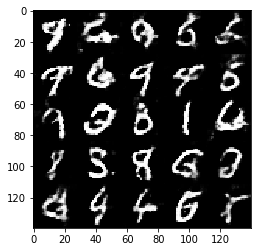

Epoch 1/ 2 ...  Discriminator Loss 1.3206 Gen Loss 0.9205
Epoch 1/ 2 ...  Discriminator Loss 1.3010 Gen Loss 0.9117
Epoch 1/ 2 ...  Discriminator Loss 1.1772 Gen Loss 0.9707
Epoch 1/ 2 ...  Discriminator Loss 1.2504 Gen Loss 1.0375
Epoch 1/ 2 ...  Discriminator Loss 1.2896 Gen Loss 0.9833
Epoch 1/ 2 ...  Discriminator Loss 1.1862 Gen Loss 0.9766
Epoch 1/ 2 ...  Discriminator Loss 1.2321 Gen Loss 0.8872
Epoch 1/ 2 ...  Discriminator Loss 1.1933 Gen Loss 1.0315
Epoch 1/ 2 ...  Discriminator Loss 1.1537 Gen Loss 1.0198
Epoch 1/ 2 ...  Discriminator Loss 1.2268 Gen Loss 0.8983


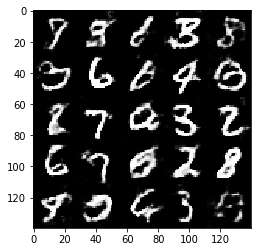

Epoch 1/ 2 ...  Discriminator Loss 1.2570 Gen Loss 0.9997
Epoch 1/ 2 ...  Discriminator Loss 1.2224 Gen Loss 0.9620
Epoch 1/ 2 ...  Discriminator Loss 1.2242 Gen Loss 1.0013
Epoch 1/ 2 ...  Discriminator Loss 1.2631 Gen Loss 0.9117
Epoch 1/ 2 ...  Discriminator Loss 1.2708 Gen Loss 0.9700


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/ 1 ...  Discriminator Loss 2.1511 Gen Loss 0.2407
Epoch 0/ 1 ...  Discriminator Loss 1.0994 Gen Loss 0.8022
Epoch 0/ 1 ...  Discriminator Loss 0.4671 Gen Loss 2.5347
Epoch 0/ 1 ...  Discriminator Loss 0.6280 Gen Loss 1.6027
Epoch 0/ 1 ...  Discriminator Loss 0.5077 Gen Loss 2.1293
Epoch 0/ 1 ...  Discriminator Loss 0.4297 Gen Loss 2.6190
Epoch 0/ 1 ...  Discriminator Loss 0.4657 Gen Loss 2.6963
Epoch 0/ 1 ...  Discriminator Loss 0.3992 Gen Loss 3.3159
Epoch 0/ 1 ...  Discriminator Loss 0.4303 Gen Loss 2.9719
Epoch 0/ 1 ...  Discriminator Loss 0.4183 Gen Loss 2.8536


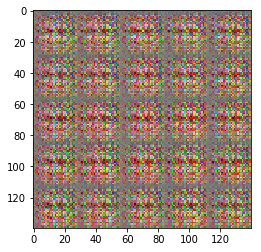

Epoch 0/ 1 ...  Discriminator Loss 0.4134 Gen Loss 3.3067
Epoch 0/ 1 ...  Discriminator Loss 0.3981 Gen Loss 3.2828
Epoch 0/ 1 ...  Discriminator Loss 0.4192 Gen Loss 3.0331
Epoch 0/ 1 ...  Discriminator Loss 0.4946 Gen Loss 2.1288
Epoch 0/ 1 ...  Discriminator Loss 0.4324 Gen Loss 2.5077
Epoch 0/ 1 ...  Discriminator Loss 0.4226 Gen Loss 4.3273
Epoch 0/ 1 ...  Discriminator Loss 0.4208 Gen Loss 4.0475
Epoch 0/ 1 ...  Discriminator Loss 0.5146 Gen Loss 2.4840
Epoch 0/ 1 ...  Discriminator Loss 0.4811 Gen Loss 2.1937
Epoch 0/ 1 ...  Discriminator Loss 0.4299 Gen Loss 3.6746


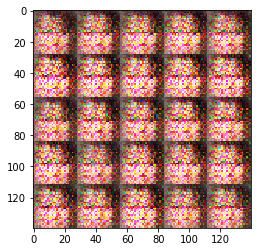

Epoch 0/ 1 ...  Discriminator Loss 0.5089 Gen Loss 2.2146
Epoch 0/ 1 ...  Discriminator Loss 0.4084 Gen Loss 3.6006
Epoch 0/ 1 ...  Discriminator Loss 0.7388 Gen Loss 4.1775
Epoch 0/ 1 ...  Discriminator Loss 1.1268 Gen Loss 0.7668
Epoch 0/ 1 ...  Discriminator Loss 0.5480 Gen Loss 1.9758
Epoch 0/ 1 ...  Discriminator Loss 0.6026 Gen Loss 2.7773
Epoch 0/ 1 ...  Discriminator Loss 0.5059 Gen Loss 2.2170
Epoch 0/ 1 ...  Discriminator Loss 0.4224 Gen Loss 3.8874
Epoch 0/ 1 ...  Discriminator Loss 0.4725 Gen Loss 3.1121
Epoch 0/ 1 ...  Discriminator Loss 0.4746 Gen Loss 2.4511


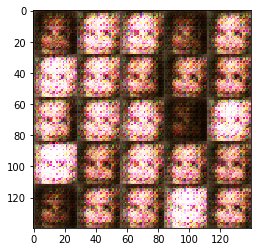

Epoch 0/ 1 ...  Discriminator Loss 0.4430 Gen Loss 3.3370
Epoch 0/ 1 ...  Discriminator Loss 0.4647 Gen Loss 2.6073
Epoch 0/ 1 ...  Discriminator Loss 0.4786 Gen Loss 2.6592
Epoch 0/ 1 ...  Discriminator Loss 0.4300 Gen Loss 3.2302
Epoch 0/ 1 ...  Discriminator Loss 0.4558 Gen Loss 2.9855
Epoch 0/ 1 ...  Discriminator Loss 0.4785 Gen Loss 2.4143
Epoch 0/ 1 ...  Discriminator Loss 0.4984 Gen Loss 2.3816
Epoch 0/ 1 ...  Discriminator Loss 0.5163 Gen Loss 2.0882
Epoch 0/ 1 ...  Discriminator Loss 0.5180 Gen Loss 2.0260
Epoch 0/ 1 ...  Discriminator Loss 0.6558 Gen Loss 1.4726


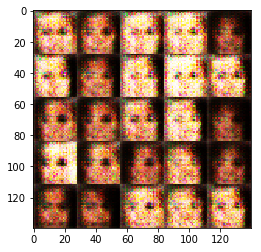

Epoch 0/ 1 ...  Discriminator Loss 0.4603 Gen Loss 3.0264
Epoch 0/ 1 ...  Discriminator Loss 0.4697 Gen Loss 2.8221
Epoch 0/ 1 ...  Discriminator Loss 0.4536 Gen Loss 2.9739
Epoch 0/ 1 ...  Discriminator Loss 0.4762 Gen Loss 2.2452
Epoch 0/ 1 ...  Discriminator Loss 0.5290 Gen Loss 3.5724
Epoch 0/ 1 ...  Discriminator Loss 0.5488 Gen Loss 1.9898
Epoch 0/ 1 ...  Discriminator Loss 0.4645 Gen Loss 3.0238
Epoch 0/ 1 ...  Discriminator Loss 0.5487 Gen Loss 4.2467
Epoch 0/ 1 ...  Discriminator Loss 0.4550 Gen Loss 2.8338
Epoch 0/ 1 ...  Discriminator Loss 0.6193 Gen Loss 1.8606


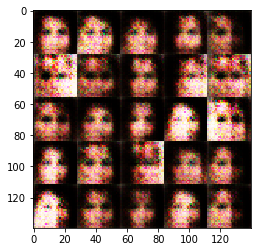

Epoch 0/ 1 ...  Discriminator Loss 1.2636 Gen Loss 7.2285
Epoch 0/ 1 ...  Discriminator Loss 0.5314 Gen Loss 2.5925
Epoch 0/ 1 ...  Discriminator Loss 0.5218 Gen Loss 3.1705
Epoch 0/ 1 ...  Discriminator Loss 0.5551 Gen Loss 1.9819
Epoch 0/ 1 ...  Discriminator Loss 0.6117 Gen Loss 1.9095
Epoch 0/ 1 ...  Discriminator Loss 0.4869 Gen Loss 2.3759
Epoch 0/ 1 ...  Discriminator Loss 0.5741 Gen Loss 2.0142
Epoch 0/ 1 ...  Discriminator Loss 0.5767 Gen Loss 2.1660
Epoch 0/ 1 ...  Discriminator Loss 0.5667 Gen Loss 1.9863
Epoch 0/ 1 ...  Discriminator Loss 0.8152 Gen Loss 1.1544


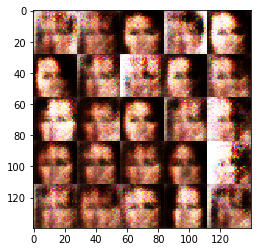

Epoch 0/ 1 ...  Discriminator Loss 0.7759 Gen Loss 1.3731
Epoch 0/ 1 ...  Discriminator Loss 0.5469 Gen Loss 2.2697
Epoch 0/ 1 ...  Discriminator Loss 0.5309 Gen Loss 2.4722
Epoch 0/ 1 ...  Discriminator Loss 0.5349 Gen Loss 2.5139
Epoch 0/ 1 ...  Discriminator Loss 0.4595 Gen Loss 2.7692
Epoch 0/ 1 ...  Discriminator Loss 0.5054 Gen Loss 2.3716
Epoch 0/ 1 ...  Discriminator Loss 0.4947 Gen Loss 2.3183
Epoch 0/ 1 ...  Discriminator Loss 0.5232 Gen Loss 2.9826
Epoch 0/ 1 ...  Discriminator Loss 0.4664 Gen Loss 2.6120
Epoch 0/ 1 ...  Discriminator Loss 0.4672 Gen Loss 2.3871


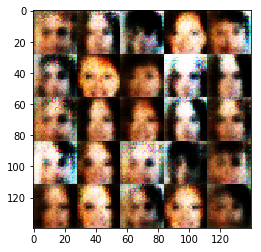

Epoch 0/ 1 ...  Discriminator Loss 0.8834 Gen Loss 1.2311
Epoch 0/ 1 ...  Discriminator Loss 0.6398 Gen Loss 2.0083
Epoch 0/ 1 ...  Discriminator Loss 0.5864 Gen Loss 2.2771
Epoch 0/ 1 ...  Discriminator Loss 0.7824 Gen Loss 1.2450
Epoch 0/ 1 ...  Discriminator Loss 0.5254 Gen Loss 2.5753
Epoch 0/ 1 ...  Discriminator Loss 0.6731 Gen Loss 1.7281
Epoch 0/ 1 ...  Discriminator Loss 0.5839 Gen Loss 1.9512
Epoch 0/ 1 ...  Discriminator Loss 0.4914 Gen Loss 2.5491
Epoch 0/ 1 ...  Discriminator Loss 0.4442 Gen Loss 2.9785
Epoch 0/ 1 ...  Discriminator Loss 0.4600 Gen Loss 3.1510


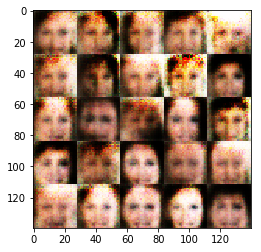

Epoch 0/ 1 ...  Discriminator Loss 0.5197 Gen Loss 2.7582
Epoch 0/ 1 ...  Discriminator Loss 0.5076 Gen Loss 2.7500
Epoch 0/ 1 ...  Discriminator Loss 0.4462 Gen Loss 3.5517
Epoch 0/ 1 ...  Discriminator Loss 0.5271 Gen Loss 2.6120
Epoch 0/ 1 ...  Discriminator Loss 0.5113 Gen Loss 3.0893
Epoch 0/ 1 ...  Discriminator Loss 0.4762 Gen Loss 3.0496
Epoch 0/ 1 ...  Discriminator Loss 0.4566 Gen Loss 3.2948
Epoch 0/ 1 ...  Discriminator Loss 0.5380 Gen Loss 2.3786
Epoch 0/ 1 ...  Discriminator Loss 0.5582 Gen Loss 2.2571
Epoch 0/ 1 ...  Discriminator Loss 0.4840 Gen Loss 2.7573


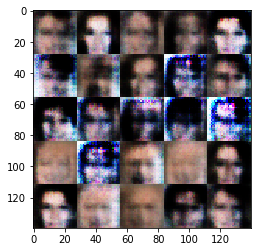

Epoch 0/ 1 ...  Discriminator Loss 0.5441 Gen Loss 2.4497
Epoch 0/ 1 ...  Discriminator Loss 0.4761 Gen Loss 2.6619
Epoch 0/ 1 ...  Discriminator Loss 0.5334 Gen Loss 2.9245
Epoch 0/ 1 ...  Discriminator Loss 0.6491 Gen Loss 1.9650
Epoch 0/ 1 ...  Discriminator Loss 0.5137 Gen Loss 2.8176
Epoch 0/ 1 ...  Discriminator Loss 0.4470 Gen Loss 3.2040
Epoch 0/ 1 ...  Discriminator Loss 0.5519 Gen Loss 2.7010
Epoch 0/ 1 ...  Discriminator Loss 0.6528 Gen Loss 2.5409
Epoch 0/ 1 ...  Discriminator Loss 0.9060 Gen Loss 1.4345
Epoch 0/ 1 ...  Discriminator Loss 0.6838 Gen Loss 1.9014


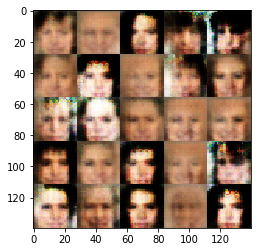

Epoch 0/ 1 ...  Discriminator Loss 0.5302 Gen Loss 2.7330
Epoch 0/ 1 ...  Discriminator Loss 0.5006 Gen Loss 2.5318
Epoch 0/ 1 ...  Discriminator Loss 0.4844 Gen Loss 2.7310
Epoch 0/ 1 ...  Discriminator Loss 0.4914 Gen Loss 2.8420
Epoch 0/ 1 ...  Discriminator Loss 0.5770 Gen Loss 2.0233
Epoch 0/ 1 ...  Discriminator Loss 0.6400 Gen Loss 1.9310
Epoch 0/ 1 ...  Discriminator Loss 0.4980 Gen Loss 2.9922
Epoch 0/ 1 ...  Discriminator Loss 0.8299 Gen Loss 1.3058
Epoch 0/ 1 ...  Discriminator Loss 0.7093 Gen Loss 2.8476
Epoch 0/ 1 ...  Discriminator Loss 0.5594 Gen Loss 2.3739


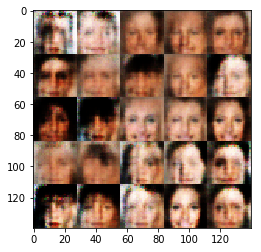

Epoch 0/ 1 ...  Discriminator Loss 0.4575 Gen Loss 3.3502
Epoch 0/ 1 ...  Discriminator Loss 0.5529 Gen Loss 2.7104
Epoch 0/ 1 ...  Discriminator Loss 0.4450 Gen Loss 2.8123
Epoch 0/ 1 ...  Discriminator Loss 0.4504 Gen Loss 3.5228
Epoch 0/ 1 ...  Discriminator Loss 0.4391 Gen Loss 3.4737
Epoch 0/ 1 ...  Discriminator Loss 0.5038 Gen Loss 2.8127
Epoch 0/ 1 ...  Discriminator Loss 0.5439 Gen Loss 2.7063
Epoch 0/ 1 ...  Discriminator Loss 0.4328 Gen Loss 3.7238
Epoch 0/ 1 ...  Discriminator Loss 0.6356 Gen Loss 2.0618
Epoch 0/ 1 ...  Discriminator Loss 0.5425 Gen Loss 2.6856


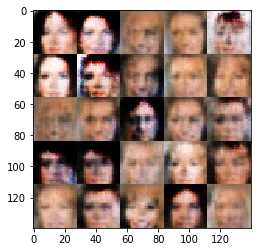

Epoch 0/ 1 ...  Discriminator Loss 0.5358 Gen Loss 2.4234
Epoch 0/ 1 ...  Discriminator Loss 0.4004 Gen Loss 4.1259
Epoch 0/ 1 ...  Discriminator Loss 0.5648 Gen Loss 3.3593
Epoch 0/ 1 ...  Discriminator Loss 0.3957 Gen Loss 4.8756
Epoch 0/ 1 ...  Discriminator Loss 0.5489 Gen Loss 1.9400
Epoch 0/ 1 ...  Discriminator Loss 0.5984 Gen Loss 3.4053
Epoch 0/ 1 ...  Discriminator Loss 0.4997 Gen Loss 3.2867
Epoch 0/ 1 ...  Discriminator Loss 0.5117 Gen Loss 2.5109
Epoch 0/ 1 ...  Discriminator Loss 0.5203 Gen Loss 3.2000
Epoch 0/ 1 ...  Discriminator Loss 0.5637 Gen Loss 3.5212


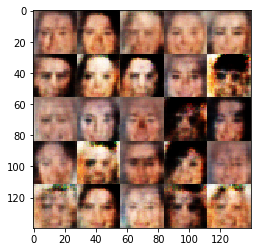

Epoch 0/ 1 ...  Discriminator Loss 0.6189 Gen Loss 1.8270
Epoch 0/ 1 ...  Discriminator Loss 0.4375 Gen Loss 3.4000
Epoch 0/ 1 ...  Discriminator Loss 0.7401 Gen Loss 3.3742
Epoch 0/ 1 ...  Discriminator Loss 0.5037 Gen Loss 2.9323
Epoch 0/ 1 ...  Discriminator Loss 0.4687 Gen Loss 3.8959
Epoch 0/ 1 ...  Discriminator Loss 0.6634 Gen Loss 1.6211
Epoch 0/ 1 ...  Discriminator Loss 0.5331 Gen Loss 2.5734
Epoch 0/ 1 ...  Discriminator Loss 0.5970 Gen Loss 2.2260
Epoch 0/ 1 ...  Discriminator Loss 0.5292 Gen Loss 2.9681
Epoch 0/ 1 ...  Discriminator Loss 0.5032 Gen Loss 2.4867


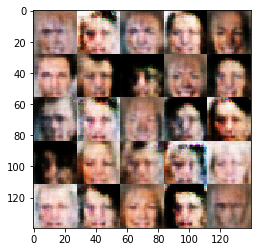

Epoch 0/ 1 ...  Discriminator Loss 0.4080 Gen Loss 3.6290
Epoch 0/ 1 ...  Discriminator Loss 0.4900 Gen Loss 2.6864
Epoch 0/ 1 ...  Discriminator Loss 0.4810 Gen Loss 2.8971
Epoch 0/ 1 ...  Discriminator Loss 0.5780 Gen Loss 2.0407
Epoch 0/ 1 ...  Discriminator Loss 0.5312 Gen Loss 2.9345
Epoch 0/ 1 ...  Discriminator Loss 0.4479 Gen Loss 3.1540
Epoch 0/ 1 ...  Discriminator Loss 1.7113 Gen Loss 0.5351
Epoch 0/ 1 ...  Discriminator Loss 1.5185 Gen Loss 4.2419
Epoch 0/ 1 ...  Discriminator Loss 0.7615 Gen Loss 3.1986
Epoch 0/ 1 ...  Discriminator Loss 0.6950 Gen Loss 1.6849


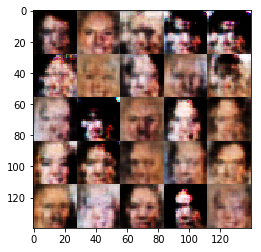

Epoch 0/ 1 ...  Discriminator Loss 0.7013 Gen Loss 2.7179
Epoch 0/ 1 ...  Discriminator Loss 0.6329 Gen Loss 1.6673
Epoch 0/ 1 ...  Discriminator Loss 0.5684 Gen Loss 2.3497
Epoch 0/ 1 ...  Discriminator Loss 0.6329 Gen Loss 2.1927
Epoch 0/ 1 ...  Discriminator Loss 0.6112 Gen Loss 2.4275
Epoch 0/ 1 ...  Discriminator Loss 0.6249 Gen Loss 2.0077
Epoch 0/ 1 ...  Discriminator Loss 0.6571 Gen Loss 4.0242
Epoch 0/ 1 ...  Discriminator Loss 0.6428 Gen Loss 1.4719
Epoch 0/ 1 ...  Discriminator Loss 0.4884 Gen Loss 2.4186
Epoch 0/ 1 ...  Discriminator Loss 0.5150 Gen Loss 2.7556


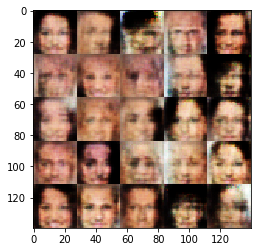

Epoch 0/ 1 ...  Discriminator Loss 0.5917 Gen Loss 1.9016
Epoch 0/ 1 ...  Discriminator Loss 0.6144 Gen Loss 1.9758
Epoch 0/ 1 ...  Discriminator Loss 0.5636 Gen Loss 2.3572
Epoch 0/ 1 ...  Discriminator Loss 0.5524 Gen Loss 2.2493
Epoch 0/ 1 ...  Discriminator Loss 0.5364 Gen Loss 3.7873
Epoch 0/ 1 ...  Discriminator Loss 0.7921 Gen Loss 3.3383
Epoch 0/ 1 ...  Discriminator Loss 1.0472 Gen Loss 3.0715
Epoch 0/ 1 ...  Discriminator Loss 0.6765 Gen Loss 2.5113
Epoch 0/ 1 ...  Discriminator Loss 0.7718 Gen Loss 1.9426
Epoch 0/ 1 ...  Discriminator Loss 0.6265 Gen Loss 1.9016


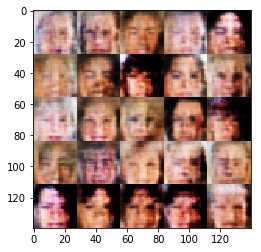

Epoch 0/ 1 ...  Discriminator Loss 0.6029 Gen Loss 1.9667
Epoch 0/ 1 ...  Discriminator Loss 0.6012 Gen Loss 2.3979
Epoch 0/ 1 ...  Discriminator Loss 0.7023 Gen Loss 1.4772
Epoch 0/ 1 ...  Discriminator Loss 0.4741 Gen Loss 2.6710
Epoch 0/ 1 ...  Discriminator Loss 0.5452 Gen Loss 2.6973
Epoch 0/ 1 ...  Discriminator Loss 0.5678 Gen Loss 2.4270
Epoch 0/ 1 ...  Discriminator Loss 0.5058 Gen Loss 2.7248
Epoch 0/ 1 ...  Discriminator Loss 0.5377 Gen Loss 2.2112
Epoch 0/ 1 ...  Discriminator Loss 0.6028 Gen Loss 2.0427
Epoch 0/ 1 ...  Discriminator Loss 0.7528 Gen Loss 1.3258


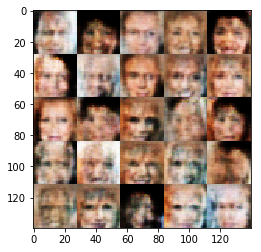

Epoch 0/ 1 ...  Discriminator Loss 0.6205 Gen Loss 1.9376
Epoch 0/ 1 ...  Discriminator Loss 0.5975 Gen Loss 2.1786
Epoch 0/ 1 ...  Discriminator Loss 0.5988 Gen Loss 2.5192
Epoch 0/ 1 ...  Discriminator Loss 0.4645 Gen Loss 3.1411
Epoch 0/ 1 ...  Discriminator Loss 0.6108 Gen Loss 1.9518
Epoch 0/ 1 ...  Discriminator Loss 0.5762 Gen Loss 2.1369
Epoch 0/ 1 ...  Discriminator Loss 0.4692 Gen Loss 4.1380
Epoch 0/ 1 ...  Discriminator Loss 0.4667 Gen Loss 3.0437
Epoch 0/ 1 ...  Discriminator Loss 0.5430 Gen Loss 3.2119
Epoch 0/ 1 ...  Discriminator Loss 0.4938 Gen Loss 2.5665


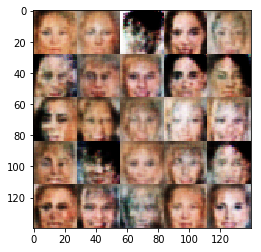

Epoch 0/ 1 ...  Discriminator Loss 1.0397 Gen Loss 3.1775
Epoch 0/ 1 ...  Discriminator Loss 0.5196 Gen Loss 2.3711
Epoch 0/ 1 ...  Discriminator Loss 0.4787 Gen Loss 3.9993
Epoch 0/ 1 ...  Discriminator Loss 0.6590 Gen Loss 1.4579
Epoch 0/ 1 ...  Discriminator Loss 0.5237 Gen Loss 2.7452
Epoch 0/ 1 ...  Discriminator Loss 0.6435 Gen Loss 1.8997
Epoch 0/ 1 ...  Discriminator Loss 0.4955 Gen Loss 2.5736
Epoch 0/ 1 ...  Discriminator Loss 0.5892 Gen Loss 2.2246
Epoch 0/ 1 ...  Discriminator Loss 0.5226 Gen Loss 3.2112
Epoch 0/ 1 ...  Discriminator Loss 0.4087 Gen Loss 4.0750


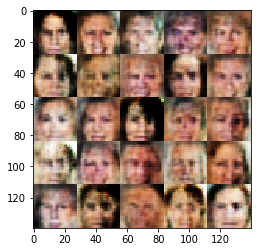

Epoch 0/ 1 ...  Discriminator Loss 0.5783 Gen Loss 2.0515
Epoch 0/ 1 ...  Discriminator Loss 0.4930 Gen Loss 3.2526
Epoch 0/ 1 ...  Discriminator Loss 0.5617 Gen Loss 2.6035
Epoch 0/ 1 ...  Discriminator Loss 0.4681 Gen Loss 2.8159
Epoch 0/ 1 ...  Discriminator Loss 0.6429 Gen Loss 2.8962
Epoch 0/ 1 ...  Discriminator Loss 0.4390 Gen Loss 3.4086
Epoch 0/ 1 ...  Discriminator Loss 0.5768 Gen Loss 2.1331
Epoch 0/ 1 ...  Discriminator Loss 0.6703 Gen Loss 2.1768
Epoch 0/ 1 ...  Discriminator Loss 0.5791 Gen Loss 2.3248
Epoch 0/ 1 ...  Discriminator Loss 0.7516 Gen Loss 1.3960


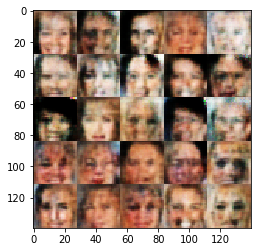

Epoch 0/ 1 ...  Discriminator Loss 0.4817 Gen Loss 3.9419
Epoch 0/ 1 ...  Discriminator Loss 0.4522 Gen Loss 3.0841
Epoch 0/ 1 ...  Discriminator Loss 0.5233 Gen Loss 2.5743
Epoch 0/ 1 ...  Discriminator Loss 1.8941 Gen Loss 0.4638
Epoch 0/ 1 ...  Discriminator Loss 0.8189 Gen Loss 2.2773
Epoch 0/ 1 ...  Discriminator Loss 0.5597 Gen Loss 2.2801
Epoch 0/ 1 ...  Discriminator Loss 0.5367 Gen Loss 2.6475
Epoch 0/ 1 ...  Discriminator Loss 0.5728 Gen Loss 2.3880
Epoch 0/ 1 ...  Discriminator Loss 0.5921 Gen Loss 2.2404
Epoch 0/ 1 ...  Discriminator Loss 0.5380 Gen Loss 2.7078


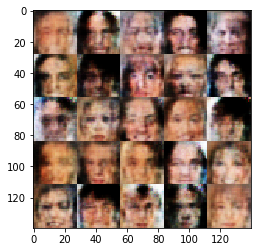

Epoch 0/ 1 ...  Discriminator Loss 0.5533 Gen Loss 2.2648
Epoch 0/ 1 ...  Discriminator Loss 0.5013 Gen Loss 2.4920
Epoch 0/ 1 ...  Discriminator Loss 0.5039 Gen Loss 4.5598
Epoch 0/ 1 ...  Discriminator Loss 0.5491 Gen Loss 2.1030
Epoch 0/ 1 ...  Discriminator Loss 0.5649 Gen Loss 2.3281
Epoch 0/ 1 ...  Discriminator Loss 0.7481 Gen Loss 1.5077
Epoch 0/ 1 ...  Discriminator Loss 0.8319 Gen Loss 2.0065
Epoch 0/ 1 ...  Discriminator Loss 0.6716 Gen Loss 2.0100
Epoch 0/ 1 ...  Discriminator Loss 0.6047 Gen Loss 1.6013
Epoch 0/ 1 ...  Discriminator Loss 0.3948 Gen Loss 4.9219


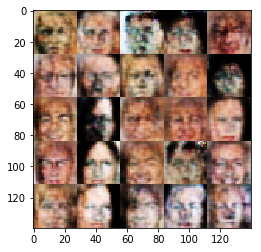

Epoch 0/ 1 ...  Discriminator Loss 0.4783 Gen Loss 4.1321
Epoch 0/ 1 ...  Discriminator Loss 0.4811 Gen Loss 2.9559
Epoch 0/ 1 ...  Discriminator Loss 0.5382 Gen Loss 1.9847
Epoch 0/ 1 ...  Discriminator Loss 0.5980 Gen Loss 1.7060
Epoch 0/ 1 ...  Discriminator Loss 0.6134 Gen Loss 2.0649
Epoch 0/ 1 ...  Discriminator Loss 0.5664 Gen Loss 2.4104
Epoch 0/ 1 ...  Discriminator Loss 0.4780 Gen Loss 4.4003
Epoch 0/ 1 ...  Discriminator Loss 0.5129 Gen Loss 2.8001
Epoch 0/ 1 ...  Discriminator Loss 0.7118 Gen Loss 1.4057
Epoch 0/ 1 ...  Discriminator Loss 0.8305 Gen Loss 1.2369


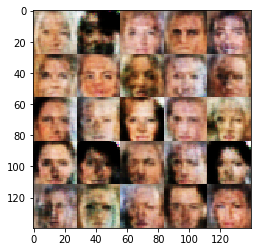

Epoch 0/ 1 ...  Discriminator Loss 0.6331 Gen Loss 2.5511
Epoch 0/ 1 ...  Discriminator Loss 0.5276 Gen Loss 2.4822
Epoch 0/ 1 ...  Discriminator Loss 0.5570 Gen Loss 2.3714
Epoch 0/ 1 ...  Discriminator Loss 0.5850 Gen Loss 2.0196
Epoch 0/ 1 ...  Discriminator Loss 0.5535 Gen Loss 2.1373
Epoch 0/ 1 ...  Discriminator Loss 0.5421 Gen Loss 2.3824
Epoch 0/ 1 ...  Discriminator Loss 0.6938 Gen Loss 1.8104
Epoch 0/ 1 ...  Discriminator Loss 0.4914 Gen Loss 3.3337
Epoch 0/ 1 ...  Discriminator Loss 0.6448 Gen Loss 2.1722
Epoch 0/ 1 ...  Discriminator Loss 0.5359 Gen Loss 2.6759


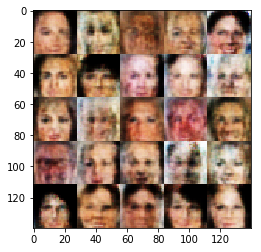

Epoch 0/ 1 ...  Discriminator Loss 0.6552 Gen Loss 1.9650
Epoch 0/ 1 ...  Discriminator Loss 0.5961 Gen Loss 2.0614
Epoch 0/ 1 ...  Discriminator Loss 0.5797 Gen Loss 1.8570
Epoch 0/ 1 ...  Discriminator Loss 0.5474 Gen Loss 2.6652
Epoch 0/ 1 ...  Discriminator Loss 0.5701 Gen Loss 2.9942
Epoch 0/ 1 ...  Discriminator Loss 0.7461 Gen Loss 2.9718
Epoch 0/ 1 ...  Discriminator Loss 0.5539 Gen Loss 2.5382
Epoch 0/ 1 ...  Discriminator Loss 0.5104 Gen Loss 2.9030
Epoch 0/ 1 ...  Discriminator Loss 0.4829 Gen Loss 2.3376
Epoch 0/ 1 ...  Discriminator Loss 0.5925 Gen Loss 2.1532


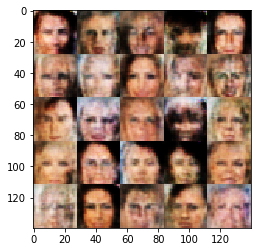

Epoch 0/ 1 ...  Discriminator Loss 0.5804 Gen Loss 1.9637
Epoch 0/ 1 ...  Discriminator Loss 0.4735 Gen Loss 3.1543
Epoch 0/ 1 ...  Discriminator Loss 0.5550 Gen Loss 2.3544
Epoch 0/ 1 ...  Discriminator Loss 0.5717 Gen Loss 2.3482
Epoch 0/ 1 ...  Discriminator Loss 0.5801 Gen Loss 2.8382
Epoch 0/ 1 ...  Discriminator Loss 0.5763 Gen Loss 2.4252
Epoch 0/ 1 ...  Discriminator Loss 1.1369 Gen Loss 1.1793
Epoch 0/ 1 ...  Discriminator Loss 0.8959 Gen Loss 1.2165
Epoch 0/ 1 ...  Discriminator Loss 0.6346 Gen Loss 2.2750
Epoch 0/ 1 ...  Discriminator Loss 0.5432 Gen Loss 3.0382


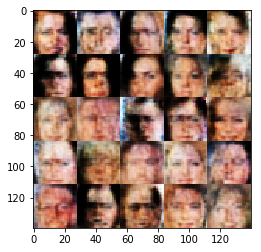

Epoch 0/ 1 ...  Discriminator Loss 0.6647 Gen Loss 2.3475
Epoch 0/ 1 ...  Discriminator Loss 0.6045 Gen Loss 2.2697
Epoch 0/ 1 ...  Discriminator Loss 0.7510 Gen Loss 1.6538
Epoch 0/ 1 ...  Discriminator Loss 0.6695 Gen Loss 2.0140
Epoch 0/ 1 ...  Discriminator Loss 0.6163 Gen Loss 2.3246
Epoch 0/ 1 ...  Discriminator Loss 0.6159 Gen Loss 2.3249
Epoch 0/ 1 ...  Discriminator Loss 0.6025 Gen Loss 2.2331
Epoch 0/ 1 ...  Discriminator Loss 0.6641 Gen Loss 2.0679
Epoch 0/ 1 ...  Discriminator Loss 0.6084 Gen Loss 3.1690
Epoch 0/ 1 ...  Discriminator Loss 0.5474 Gen Loss 2.1549


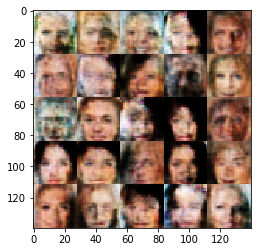

Epoch 0/ 1 ...  Discriminator Loss 0.6646 Gen Loss 2.5228
Epoch 0/ 1 ...  Discriminator Loss 0.5613 Gen Loss 1.9766
Epoch 0/ 1 ...  Discriminator Loss 0.6605 Gen Loss 1.9434
Epoch 0/ 1 ...  Discriminator Loss 0.6201 Gen Loss 1.7975
Epoch 0/ 1 ...  Discriminator Loss 0.5782 Gen Loss 2.3083
Epoch 0/ 1 ...  Discriminator Loss 0.6801 Gen Loss 2.0682
Epoch 0/ 1 ...  Discriminator Loss 1.3152 Gen Loss 0.9815
Epoch 0/ 1 ...  Discriminator Loss 1.0251 Gen Loss 1.3258
Epoch 0/ 1 ...  Discriminator Loss 0.8401 Gen Loss 1.4813
Epoch 0/ 1 ...  Discriminator Loss 0.6511 Gen Loss 1.9987


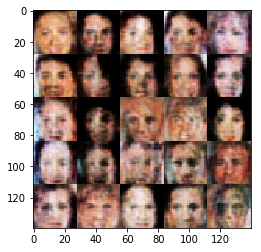

Epoch 0/ 1 ...  Discriminator Loss 0.5780 Gen Loss 2.6415
Epoch 0/ 1 ...  Discriminator Loss 0.5573 Gen Loss 2.7968
Epoch 0/ 1 ...  Discriminator Loss 0.6720 Gen Loss 2.6686
Epoch 0/ 1 ...  Discriminator Loss 0.5807 Gen Loss 2.3610
Epoch 0/ 1 ...  Discriminator Loss 0.6399 Gen Loss 1.9923
Epoch 0/ 1 ...  Discriminator Loss 0.6275 Gen Loss 2.6446
Epoch 0/ 1 ...  Discriminator Loss 0.6165 Gen Loss 2.3451
Epoch 0/ 1 ...  Discriminator Loss 0.6374 Gen Loss 1.8981
Epoch 0/ 1 ...  Discriminator Loss 0.7782 Gen Loss 2.0366
Epoch 0/ 1 ...  Discriminator Loss 0.6405 Gen Loss 1.8058


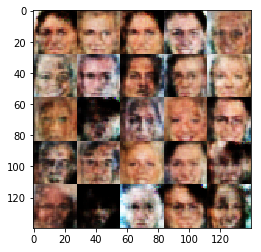

Epoch 0/ 1 ...  Discriminator Loss 0.6417 Gen Loss 2.7460
Epoch 0/ 1 ...  Discriminator Loss 0.5904 Gen Loss 2.9777
Epoch 0/ 1 ...  Discriminator Loss 0.5815 Gen Loss 2.0693
Epoch 0/ 1 ...  Discriminator Loss 0.6455 Gen Loss 2.2393
Epoch 0/ 1 ...  Discriminator Loss 0.6933 Gen Loss 1.5916
Epoch 0/ 1 ...  Discriminator Loss 0.6322 Gen Loss 1.9348
Epoch 0/ 1 ...  Discriminator Loss 0.7065 Gen Loss 2.3155
Epoch 0/ 1 ...  Discriminator Loss 0.6725 Gen Loss 2.8555
Epoch 0/ 1 ...  Discriminator Loss 0.7502 Gen Loss 2.5153
Epoch 0/ 1 ...  Discriminator Loss 0.6722 Gen Loss 1.8591


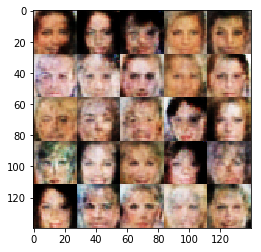

Epoch 0/ 1 ...  Discriminator Loss 0.6972 Gen Loss 2.5093
Epoch 0/ 1 ...  Discriminator Loss 0.6764 Gen Loss 3.0742
Epoch 0/ 1 ...  Discriminator Loss 0.5704 Gen Loss 2.3825
Epoch 0/ 1 ...  Discriminator Loss 0.6458 Gen Loss 1.8191
Epoch 0/ 1 ...  Discriminator Loss 0.4896 Gen Loss 3.1374
Epoch 0/ 1 ...  Discriminator Loss 0.5490 Gen Loss 2.6027


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.